In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# Extract the flower.zip file
zip_file_path = '/content/Flower.zip'
extract_dir = 'flower_dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



In [3]:
# Path to the extracted dataset
image_dir = os.path.join(extract_dir)

In [43]:
IMG_SIZE = 64
BATCH_SIZE = 32
LATENT_DIM = 100
EPOCHS = 5000

In [6]:
def load_images(image_dir, img_size):
    images = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_path = os.path.join(root, file)
                image = Image.open(image_path).resize((img_size, img_size))
                image = np.array(image) / 255.0  # Normalize to [0, 1]
                if image.shape[-1] == 3:  # Ensure it's RGB
                    images.append(image)
    return np.array(images)

In [7]:
# Load and preprocess dataset
data = load_images(image_dir, IMG_SIZE)
print(f"Dataset loaded with {data.shape[0]} images.")

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


Dataset loaded with 325 images.


In [24]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        Dense(8 * 8 * 256, input_dim=latent_dim),
        Reshape((8, 8, 256)),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(3, (4, 4), strides=(2, 2), activation='tanh', padding='same'),
    ])
    return model


def build_discriminator(img_size):
    model = tf.keras.Sequential([
        Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(img_size, img_size, 3)),
        LeakyReLU(alpha=0.2),
        Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dense(1, activation='sigmoid'),
    ])
    return model

In [25]:
def gan_loss_fn(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
generator = build_generator(LATENT_DIM)
discriminator = build_discriminator(IMG_SIZE)


In [27]:
@tf.function
def train_step(generator, discriminator, images, latent_dim):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
        disc_loss = gan_loss_fn(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Calculate accuracy
    gen_accuracy = tf.reduce_mean(tf.cast(fake_output > 0.5, tf.float32)) * 100
    disc_accuracy = (tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32)) + tf.reduce_mean(tf.cast(fake_output <= 0.5, tf.float32))) / 2 * 100

    return gen_loss, disc_loss, gen_accuracy, disc_accuracy


In [28]:
def train(generator, discriminator, dataset, epochs, latent_dim):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for image_batch in dataset:
            gen_loss, disc_loss, gen_accuracy, disc_accuracy = train_step(generator, discriminator, image_batch, latent_dim)
        print(f"Generator loss: {gen_loss:.4f}, Discriminator loss: {disc_loss:.4f}")
        print(f"Generator accuracy: {gen_accuracy:.2f}%, Discriminator accuracy: {disc_accuracy:.2f}%")


In [44]:
train(generator, discriminator, dataset, EPOCHS, LATENT_DIM)

Streaming output truncated to the last 5000 lines.
Generator loss: 9.2656, Discriminator loss: 0.0003
Generator accuracy: 0.00%, Discriminator accuracy: 100.00%
Epoch 3335/5000
Generator loss: 6.9745, Discriminator loss: 0.0022
Generator accuracy: 0.00%, Discriminator accuracy: 100.00%
Epoch 3336/5000
Generator loss: 7.8051, Discriminator loss: 0.0009
Generator accuracy: 0.00%, Discriminator accuracy: 100.00%
Epoch 3337/5000
Generator loss: 7.6145, Discriminator loss: 0.4020
Generator accuracy: 0.00%, Discriminator accuracy: 80.00%
Epoch 3338/5000
Generator loss: 15.9935, Discriminator loss: 0.0000
Generator accuracy: 0.00%, Discriminator accuracy: 100.00%
Epoch 3339/5000
Generator loss: 11.8953, Discriminator loss: 0.0001
Generator accuracy: 0.00%, Discriminator accuracy: 100.00%
Epoch 3340/5000
Generator loss: 9.7053, Discriminator loss: 0.0005
Generator accuracy: 0.00%, Discriminator accuracy: 100.00%
Epoch 3341/5000
Generator loss: 9.8824, Discriminator loss: 0.0114
Generator accur

In [45]:
import matplotlib.pyplot as plt
def evaluate_generator(generator, latent_dim, num_images=16):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()


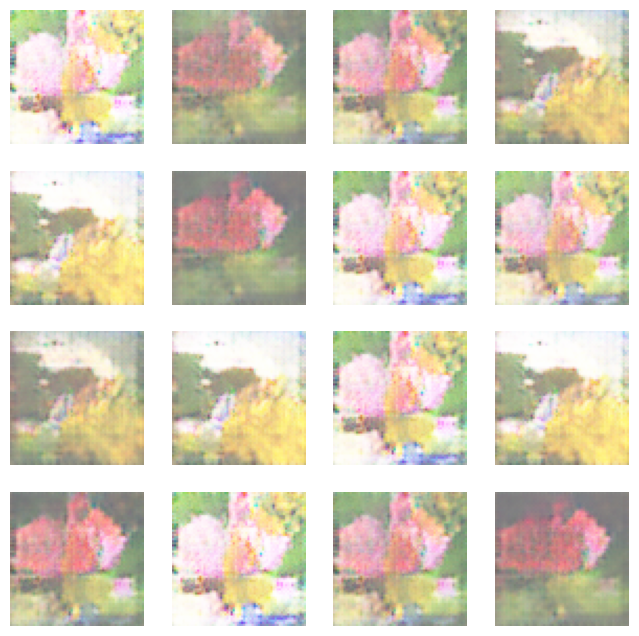

In [46]:
evaluate_generator(generator, LATENT_DIM)